# Training a neural network with McSnow selfcollection output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'
fname1=mdir+edir+'autocon_train_small.nc'
fname2=mdir+edir+'autocon_test_small.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 5, ii: 5, j: 5, jj: 5, k: 3, kk: 3, n: 2, nn: 2, nt: 4000)
Coordinates:
  * n           (n) int32 0 1
  * i           (i) int32 400 600 800 1000 2000
  * j           (j) int32 11 12 13 14 15
  * k           (k) int32 0 1 2
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n, i, j, k, nt) floa

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    self = xr.open_dataset(fname).self_rain.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nr   = xr.open_dataset(fname).Nr.values
    tau  = xr.open_dataset(fname).tau.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    self_min = 7e-10
    Xr = np.log(Lr/Nr, where=Nr>N_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    self = np.log(self, where=self>self_min, out=np.nan*self)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ self.ravel(), Lr.ravel(), Nr.ravel(), Xr.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = [ 'self','Lr','Nr','Xr','tau' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


### Inspect the data

In [6]:
dataset_train.describe()

self            Lr            Nr            Xr           tau
count  26996.000000  26996.000000  26996.000000  26996.000000  26996.000000
mean       0.441615     -8.779129      8.376693    -17.155884     -1.429725
std        4.383461      2.104487      2.241570      3.328238      2.068013
min      -17.727533    -16.876722      2.907840    -22.034079     -9.967376
25%       -1.179169     -9.743891      6.624888    -20.417099     -2.374866
50%        1.288697     -7.847311      8.655449    -17.405974     -0.197520
75%        3.384582     -7.423993     10.222714    -14.097332     -0.010076
max        8.206409     -6.217121     13.366846    -10.716539     -0.001001

In [7]:
dataset_test.describe()

self            Lr            Nr            Xr           tau
count  10265.000000  10265.000000  10265.000000  10265.000000  10265.000000
mean       0.597013     -8.729974      8.470391    -17.200420     -1.489335
std        4.433526      2.167677      2.217008      3.343723      2.148907
min      -17.727533    -18.104004      3.243576    -21.945543    -10.838027
25%       -0.985365     -9.735630      6.718659    -20.474104     -2.481498
50%        1.490111     -7.643188      8.761494    -17.481665     -0.210053
75%        3.591964     -7.275461     10.294238    -14.125299     -0.010337
max        7.536855     -6.504746     12.950388    -10.629810     -0.001001

### Reduce the data

In [8]:
def reduce_data(dataset):
    idx = dataset[ dataset['Lr'] < np.log(1e-7) ].index
    dataset.drop(idx,inplace=True)
#    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
#    dataset.drop(idx,inplace=True)
    return dataset

In [9]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [10]:
dataset_train.describe()

self            Lr            Nr            Xr           tau
count  26970.000000  26970.000000  26970.000000  26970.000000  26970.000000
mean       0.456632     -8.771737      8.379766    -17.151564     -1.422545
std        4.357948      2.091960      2.240452      3.326925      2.055996
min      -17.727533    -16.111021      2.907840    -22.034079     -9.353137
25%       -1.171256     -9.737632      6.631882    -20.410109     -2.365215
50%        1.297175     -7.847091      8.658063    -17.400046     -0.196108
75%        3.385708     -7.423930     10.224206    -14.094834     -0.010060
max        8.206409     -6.217121     13.366846    -10.716539     -0.001001

In [11]:
dataset_test.describe()

self            Lr            Nr            Xr           tau
count  10247.000000  10247.000000  10247.000000  10247.000000  10247.000000
mean       0.621977     -8.715956      8.476564    -17.192575     -1.475430
std        4.395008      2.143480      2.213897      3.341397      2.124880
min      -17.727533    -16.102262      3.262797    -21.945543     -9.209706
25%       -0.970894     -9.715749      6.728307    -20.466374     -2.464180
50%        1.501345     -7.642585      8.767837    -17.466673     -0.208714
75%        3.593737     -7.275364     10.296203    -14.121655     -0.010307
max        7.536855     -6.504746     12.950388    -10.629810     -0.001001

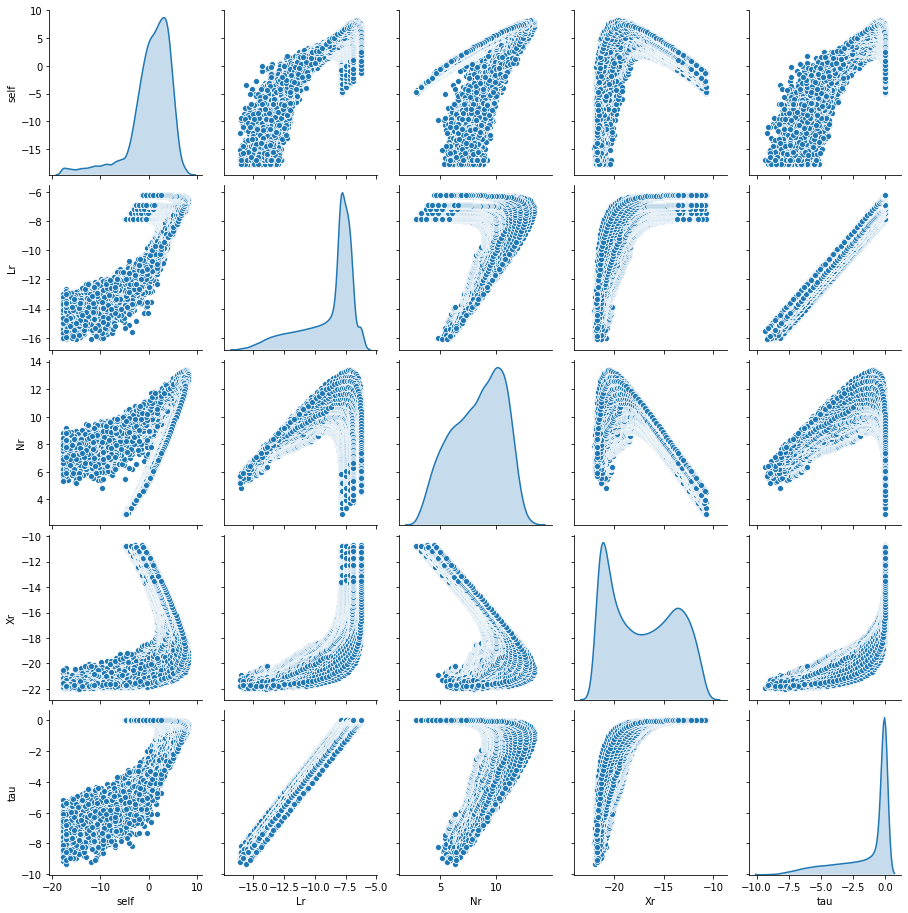

In [12]:
sns.pairplot(dataset_train[['self','Lr','Nr','Xr','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [13]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [14]:
train_dataset0 = train_dataset0.drop(['Xr','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Nr','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['Xr'], axis=1)
train_dataset3 = train_dataset3.drop(['Nr'], axis=1)
#train_dataset4 = train_dataset4.drop(['tau'], axis=1)

In [15]:
test_dataset0 = test_dataset0.drop(['Xr','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Nr','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['Xr'], axis=1)
test_dataset3 = test_dataset3.drop(['Nr'], axis=1)
#test_dataset4 = test_dataset4.drop(['tau'], axis=1)

In [16]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("self")
train_stats0 = train_stats0.transpose()
train_stats0

count      mean       std        min       25%       50%        75%  \
Lr  26970.0 -8.771737  2.091960 -16.111021 -9.737632 -7.847091  -7.423930   
Nr  26970.0  8.379766  2.240452   2.907840  6.631882  8.658063  10.224206   

          max  
Lr  -6.217121  
Nr  13.366846

In [17]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lr  26970.0  -8.771737  2.091960 -16.111021  -9.737632  -7.847091  -7.423930   
Xr  26970.0 -17.151564  3.326925 -22.034079 -20.410109 -17.400046 -14.094834   

          max  
Lr  -6.217121  
Xr -10.716539

In [18]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self")
train_stats2 = train_stats2.transpose()
train_stats2

count      mean       std        min       25%       50%        75%  \
Lr   26970.0 -8.771737  2.091960 -16.111021 -9.737632 -7.847091  -7.423930   
Nr   26970.0  8.379766  2.240452   2.907840  6.631882  8.658063  10.224206   
tau  26970.0 -1.422545  2.055996  -9.353137 -2.365215 -0.196108  -0.010060   

           max  
Lr   -6.217121  
Nr   13.366846  
tau  -0.001001

In [19]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lr   26970.0  -8.771737  2.091960 -16.111021  -9.737632  -7.847091  -7.423930   
Xr   26970.0 -17.151564  3.326925 -22.034079 -20.410109 -17.400046 -14.094834   
tau  26970.0  -1.422545  2.055996  -9.353137  -2.365215  -0.196108  -0.010060   

           max  
Lr   -6.217121  
Xr  -10.716539  
tau  -0.001001

In [20]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("self")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%        75%  \
Lr   26970.0  -8.771737  2.091960 -16.111021  -9.737632  -7.847091  -7.423930   
Nr   26970.0   8.379766  2.240452   2.907840   6.631882   8.658063  10.224206   
Xr   26970.0 -17.151564  3.326925 -22.034079 -20.410109 -17.400046 -14.094834   
tau  26970.0  -1.422545  2.055996  -9.353137  -2.365215  -0.196108  -0.010060   

           max  
Lr   -6.217121  
Nr   13.366846  
Xr  -10.716539  
tau  -0.001001

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [21]:
train_labels0 = train_dataset0.pop('self')
train_labels1 = train_dataset1.pop('self')
train_labels2 = train_dataset2.pop('self')
train_labels3 = train_dataset3.pop('self')
train_labels4 = train_dataset4.pop('self')

test_labels0  = test_dataset0.pop('self')
test_labels1  = test_dataset1.pop('self')
test_labels2  = test_dataset2.pop('self')
test_labels3  = test_dataset3.pop('self')
test_labels4  = test_dataset4.pop('self')

### Normalize the data

In [22]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [23]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lr  26970.0 -0.000010  1.000004 -3.508328 -0.461718  0.442000  0.644279   
Nr  26970.0  0.000006  1.000000 -2.442331 -0.780148  0.124215  0.823244   

         max  
Lr  1.221159  
Nr  2.225926

In [24]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lr  26970.0 -0.000010  1.000004 -3.508328 -0.461718  0.442000  0.644279   
Xr  26970.0  0.000007  0.999999 -1.467576 -0.979447 -0.074688  0.918785   

         max  
Lr  1.221159  
Xr  1.934226

In [25]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean       std       min       25%       50%       75%  \
Lr   26970.0 -0.000010  1.000004 -3.508328 -0.461718  0.442000  0.644279   
Nr   26970.0  0.000006  1.000000 -2.442331 -0.780148  0.124215  0.823244   
tau  26970.0  0.000006  1.000001 -3.857299 -0.458498  0.596517  0.687008   

          max  
Lr   1.221159  
Nr   2.225926  
tau  0.691414

In [26]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count      mean       std       min       25%       50%       75%  \
Lr   26970.0 -0.000010  1.000004 -3.508328 -0.461718  0.442000  0.644279   
Xr   26970.0  0.000007  0.999999 -1.467576 -0.979447 -0.074688  0.918785   
tau  26970.0  0.000006  1.000001 -3.857299 -0.458498  0.596517  0.687008   

          max  
Lr   1.221159  
Xr   1.934226  
tau  0.691414

In [27]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count      mean       std       min       25%       50%       75%  \
Lr   26970.0 -0.000010  1.000004 -3.508328 -0.461718  0.442000  0.644279   
Nr   26970.0  0.000006  1.000000 -2.442331 -0.780148  0.124215  0.823244   
Xr   26970.0  0.000007  0.999999 -1.467576 -0.979447 -0.074688  0.918785   
tau  26970.0  0.000006  1.000001 -3.857299 -0.458498  0.596517  0.687008   

          max  
Lr   1.221159  
Nr   2.225926  
Xr   1.934226  
tau  0.691414

# The model

## Build the model

In [28]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [29]:

#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [31]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.3286043],
       [-1.2978013],
       [-1.2890694],
       [-1.2837714],
       [-1.2788815],
       [-1.27023  ],
       [-1.2652371],
       [-1.2579995],
       [-1.2502313],
       [-1.2405055]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [32]:
# maximum number, but we use early stopping
EPOCHS = 1000

# part of training data that is used for validation during training
VALSPLIT = 0.3

# learning rate
learn = 1e-3        # original value was 1e-3

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [33]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.2414,  mae:1.0308,  mse:4.2414,  val_loss:1.7921,  val_mae:0.6283,  val_mse:1.7921,  
....................................................................

Text(0, 0.5, 'MAE')

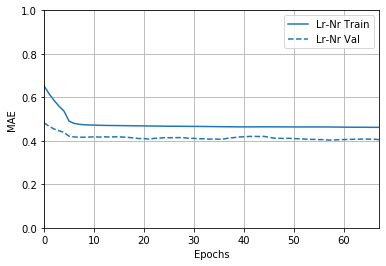

In [34]:
histories['Lr-Nr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [35]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.5804,  mae:1.0896,  mse:4.5804,  val_loss:2.0724,  val_mae:0.6391,  val_mse:2.0724,  
........................................................

Text(0, 0.5, 'MAE')

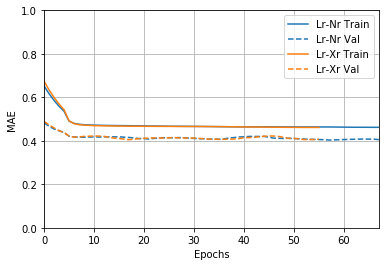

In [36]:
histories['Lr-Xr'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [37]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.8508,  mae:0.9263,  mse:3.8508,  val_loss:1.9000,  val_mae:0.5655,  val_mse:1.9000,  
...........................................

Text(0, 0.5, 'MAE')

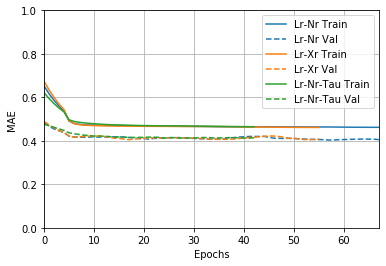

In [38]:
histories['Lr-Nr-tau'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [39]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.1742,  mae:0.9886,  mse:4.1742,  val_loss:1.8975,  val_mae:0.6644,  val_mse:1.8975,  
..........................................

Text(0, 0.5, 'MAE')

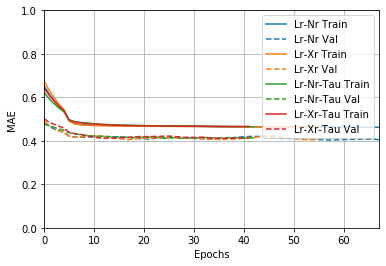

In [40]:
histories['Lr-Xr-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE of AU')

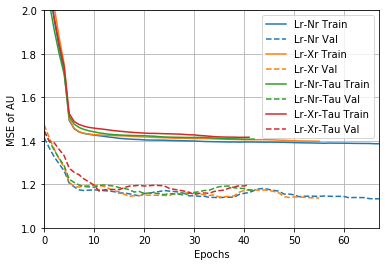

In [41]:
plotter.plot(histories, metric = "mse")
plt.ylim([1, 2])
plt.ylabel('MSE of AU')

In [42]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

10247/10247 - 0s - loss: 1.2868 - mae: 0.4323 - mse: 1.2868
Testing set for model 0, Mean Abs Error:    0.43226


In [43]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

10247/10247 - 0s - loss: 1.2806 - mae: 0.4318 - mse: 1.2806
Testing set for model 1, Mean Abs Error:    0.43176


In [44]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae2))

10247/10247 - 0s - loss: 1.3572 - mae: 0.4498 - mse: 1.3572
Testing set for model 1, Mean Abs Error:    0.44981


In [45]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae3))

10247/10247 - 0s - loss: 1.3625 - mae: 0.4603 - mse: 1.3625
Testing set for model 1, Mean Abs Error:    0.46029


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

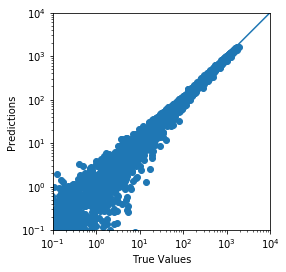

In [46]:
test_self0 = np.exp(test_labels0)
test_self1 = np.exp(test_labels1)
test_self2 = np.exp(test_labels2)
test_self3 = np.exp(test_labels3)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

amin, amax = 1e-1, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_self0, test_predict0)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

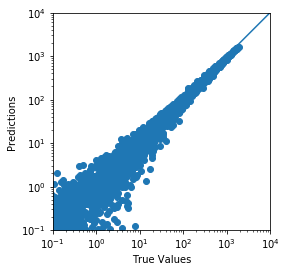

In [47]:
a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [48]:
test_dataset0.describe()

Lr            Nr
count  10247.000000  10247.000000
mean      -8.715956      8.476564
std        2.143480      2.213897
min      -16.102262      3.262797
25%       -9.715749      6.728307
50%       -7.642585      8.767837
75%       -7.275364     10.296203
max       -6.504746     12.950388

## SB2001 selfcollection rate

In [49]:
kcr = 5.78       # Long kernel in m3 kg-1 s-1 
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 

qr  = np.exp(np.array(test_dataset0.Lr))
nr  = np.exp(np.array(test_dataset0.Nr))

selfSB = kcr * qr * nr

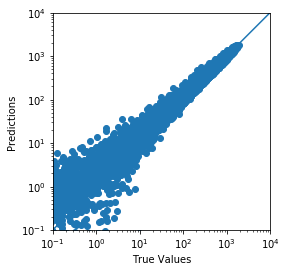

In [50]:
test_predict_sb = selfSB

a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [51]:
self0 = test_predict0
self1 = test_predict1
self2 = test_predict2
self3 = test_predict3

selfTruth = test_self0

In [52]:
np.max(selfTruth)

1875.9205322265625

In [53]:
def mean_abs_error(var, varTrue):  
    return np.mean(np.abs(var - varTrue))

def mean_sqr_error(var, varTrue):    
    return np.sqrt(np.mean((var - varTrue)**2))                   

In [54]:
mae0 = mean_abs_error(self0,test_self0)
mae1 = mean_abs_error(self1,test_self1)
mae2 = mean_abs_error(self2,test_self2)
mae3 = mean_abs_error(self3,test_self3)
maeSB = mean_abs_error(selfSB,selfTruth)

mse0 = mean_sqr_error(self0,test_self0)
mse1 = mean_sqr_error(self1,test_self1)
mse2 = mean_sqr_error(self1,test_self2)
mse3 = mean_sqr_error(self1,test_self3)
mseSB = mean_sqr_error(selfSB,selfTruth)

mae = [ mae0, mae1, mae2, mae3, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mseSB ] #, mseSB2, mseKK, msePwr ]

In [55]:
mae

[3.3873584270477295,
 4.3325018882751465,
 4.8799543380737305,
 6.48764181137085,
 6.9032111167907715]

In [56]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Lr-Nr', 'Lr-Xr', 'Lr-Nr-tau', 'Lr-Xr-tau', 'SB2001']

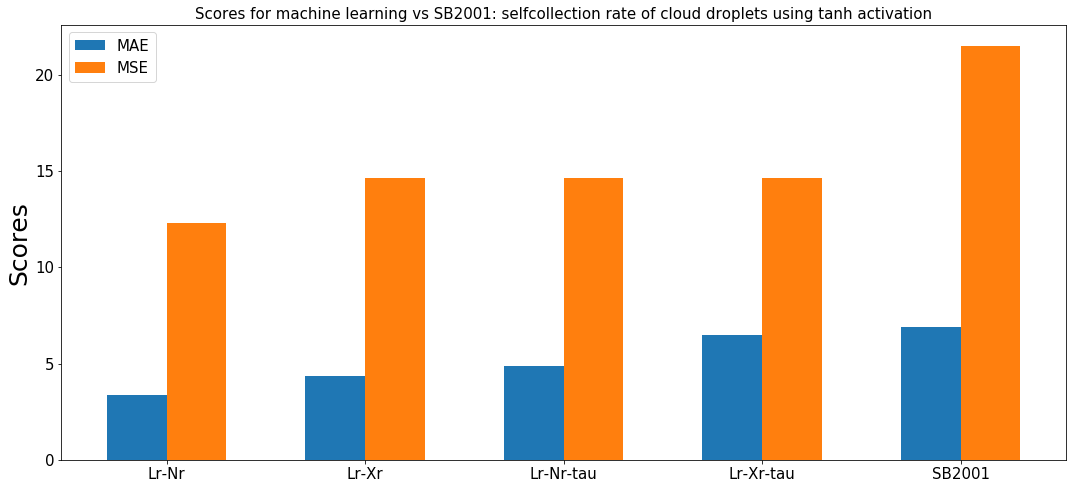

In [57]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: selfcollection rate of cloud droplets using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



# Save models and normalization

In [58]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model0.save('saved_model/selfrain_v4_LrNr_'+activ+'_16x16x16') 
model1.save('saved_model/selfrain_v4_LrXr_'+activ+'_16x16x16') 
model2.save('saved_model/selfrain_v4_LrNrTau_'+activ+'_16x16x16') 
model3.save('saved_model/selfrain_v4_LrXrTau_'+activ+'_16x16x16') 


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/selfrain_v4_LrNr_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/selfrain_v4_LrXr_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/selfrain_v4_LrNrTau_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/selfrain_v4_LrXrTau_tanh_16x16x16/assets


In [59]:
# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model/selfrain_v4_LrNr_'+activ+'_16x16x16'+'_norm.pickle')
train_stats1.to_pickle('saved_model/selfrain_v4_LrXr_'+activ+'_16x16x16'+'_norm.pickle')
train_stats2.to_pickle('saved_model/selfrain_v4_LrNrTau_'+activ+'_16x16x16'+'_norm.pickle')
train_stats3.to_pickle('saved_model/selfrain_v4_LrXrTau_'+activ+'_16x16x16'+'_norm.pickle')
